In [1]:
%matplotlib inline

from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.applications.resnet50 import ResNet50
from keras.callbacks import ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.utils import np_utils
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

HEIGHT = 224
WIDTH = 224

Using TensorFlow backend.


In [6]:
#split in training and validation data https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html
#yay, also works on dataframes: https://stackoverflow.com/a/24151789/227081

train, valid = train_test_split(pd.read_csv('train.tsv', sep='\t', header=0), test_size=0.2)
print(train.size)
print(train.head())
print(valid.size)
valid.head()



11612
           file                                label
4907   4910.png                        Salad & cress
2491  2491.jpeg        Cucumber, tomatoes & avocados
7077  7082.jpeg                        Salad & cress
5473  5477.jpeg  Bell peppers, zucchinis & eggplants
1601   1601.png                    Pork, beef & lamb
2904


,file,label
6919,6924.png,Citrus fruits
5974,5978.jpeg,Minced meat & meatballs
97,97.png,"Kiwis, grapes & mango"
5611,5615.png,"Kiwis, grapes & mango"
1573,1573.jpeg,Pre-baked breads


In [7]:
def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(HEIGHT, WIDTH))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(prefix, img_paths):
    list_of_tensors = [path_to_tensor(prefix + img_path) for img_path in tqdm(img_paths)]
    return preprocess_input(np.vstack(list_of_tensors))

X_train = paths_to_tensor("train/", np.array(train['file']))
X_valid = paths_to_tensor("train/", np.array(valid['file']))


  0%|          | 3/5806 [00:00<08:17, 11.66it/s]/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/PIL/Image.py:931: UserWarning: Palette images with Transparency   expressed in bytes should be converted to RGBA images
  'to RGBA images')

 38%|███▊      | 2219/5806 [00:51<02:48, 21.25it/s]


 77%|███████▋  | 4453/5806 [01:46<00:48, 27.64it/s]


 66%|██████▌   | 961/1452 [00:21<00:16, 29.79it/s]


100%|██████████| 1452/1452 [00:31<00:00, 46.08it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


file          2891.png
label    Citrus fruits
Name: 2891, dtype: object


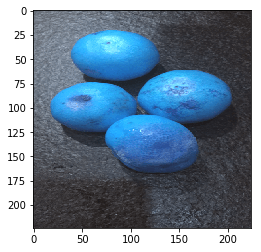

In [8]:
print(valid.iloc[10])
plt.imshow((X_valid[10]+128.)/255.)
#note colors are not correct because of Keras Resnet50 preprocessing
# can probably fix this through this: https://stackoverflow.com/questions/38538952/how-to-swap-blue-and-green-channel-in-an-image-using-opencv


In [9]:
#quick test to see if we detect a banana (954)
#dictionary is at https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a
ResNet50_model = ResNet50(weights='imagenet')
np.argmax(ResNet50_model.predict(np.expand_dims(X_valid[10], axis=0)))

102858752/102853048 [==============================] - 5s 0us/step


950

In [10]:
labels = train['label'].unique()
labels

array(['Salad & cress', 'Cucumber, tomatoes & avocados',
       'Bell peppers, zucchinis & eggplants', 'Pork, beef & lamb',
       'Cheese', 'Bananas, apples & pears', 'Kiwis, grapes & mango',
       'Pre-baked breads', 'Berries & cherries', 'Poultry',
       'Pudding, yogurt & quark', 'Milk',
       'Asparagus, string beans & brussels sprouts', 'Eggs', 'Potatoes',
       'Fresh bread', 'Nectarines, peaches & apricots',
       'Lunch & Deli Meats', 'Citrus fruits',
       'Onions, leek, garlic & beets', 'Fish',
       'Broccoli, cauliflowers, carrots & radish',
       'Minced meat & meatballs', 'Fresh herbs',
       'Pineapples, melons & passion fruit'], dtype=object)

In [11]:
one_hot_encoding = preprocessing.LabelBinarizer()
one_hot_encoding.fit(labels)
y_train = one_hot_encoding.transform(np.array(train['label']))
y_valid = one_hot_encoding.transform(np.array(valid['label']))
one_hot_encoding.inverse_transform(np.array([y_valid[10]]))

array(['Citrus fruits'], dtype='<U42')

In [12]:
print(len(train))
print(len(X_train))
print(len(y_train))
print(len(X_valid))
print(len(y_valid))

5806
5806
5806
1452
1452


In [13]:
model = Sequential()
model.add(ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape=(HEIGHT, WIDTH, 3)))
for layer in model.layers:
    layer.trainable = False

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 4s 0us/step


In [14]:
model.add(GlobalAveragePooling2D())
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(labels.size, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 25)                25625     
Total params: 25,711,513
Trainable params: 2,123,801
Non-trainable params: 23,587,712
_________________________________________________________________


In [15]:
opt = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.1)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [ ]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.Resnet50.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(X_train, y_train, 
          validation_data=(X_valid, y_valid),
          epochs=200, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 5806 samples, validate on 1452 samples
Epoch 1/200
5800/5806 [============================>.] - ETA: 0s - loss: 1.7603 - acc: 0.5184

In [ ]:
# TODO
#model.load_weights('saved_models/weights.best.from_scratch.hdf5')
# load test file into "tensor" and get prediction ->
# np.argmax(model.predict(np.expand_dims(tensor, axis=0)))

# write to TSV

In [2]:
import tensorflow as tf
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)

with tf.Session() as sess:
    print (sess.run(c))

InvalidArgumentError: Cannot assign a device for operation 'MatMul': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a, b)]]

Caused by op 'MatMul', defined at:
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 486, in start
    self.io_loop.start()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 422, in run_forever
    self._run_once()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/base_events.py", line 1432, in _run_once
    handle._run()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/asyncio/events.py", line 145, in _run
    self._callback(*self._args)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/platform/asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tornado/stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-2-3a5be606bcc9>", line 5, in <module>
    c = tf.matmul(a, b)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py", line 2014, in matmul
    a, b, transpose_a=transpose_a, transpose_b=transpose_b, name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/gen_math_ops.py", line 4279, in mat_mul
    name=name)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/op_def_library.py", line 787, in _apply_op_helper
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 3414, in create_op
    op_def=op_def)
  File "/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/framework/ops.py", line 1740, in __init__
    self._traceback = self._graph._extract_stack()  # pylint: disable=protected-access

InvalidArgumentError (see above for traceback): Cannot assign a device for operation 'MatMul': Operation was explicitly assigned to /device:GPU:0 but available devices are [ /job:localhost/replica:0/task:0/device:CPU:0 ]. Make sure the device specification refers to a valid device.
	 [[Node: MatMul = MatMul[T=DT_FLOAT, transpose_a=false, transpose_b=false, _device="/device:GPU:0"](a, b)]]
